## XOR神经网络学习可视化

[[0.47373998 0.4740199  0.47429988 ... 0.50089496 0.5011749  0.5014549 ]
 [0.47394535 0.4742253  0.47450525 ... 0.50110036 0.5013803  0.5016602 ]
 [0.47415075 0.4744307  0.47471064 ... 0.50130576 0.5015857  0.5018656 ]
 ...
 [0.49366248 0.4939424  0.49422237 ... 0.52081746 0.5210974  0.5213774 ]
 [0.49386784 0.4941478  0.49442774 ... 0.52102286 0.5213028  0.5215827 ]
 [0.49407324 0.49435318 0.49463314 ... 0.52122825 0.5215082  0.5217881 ]]


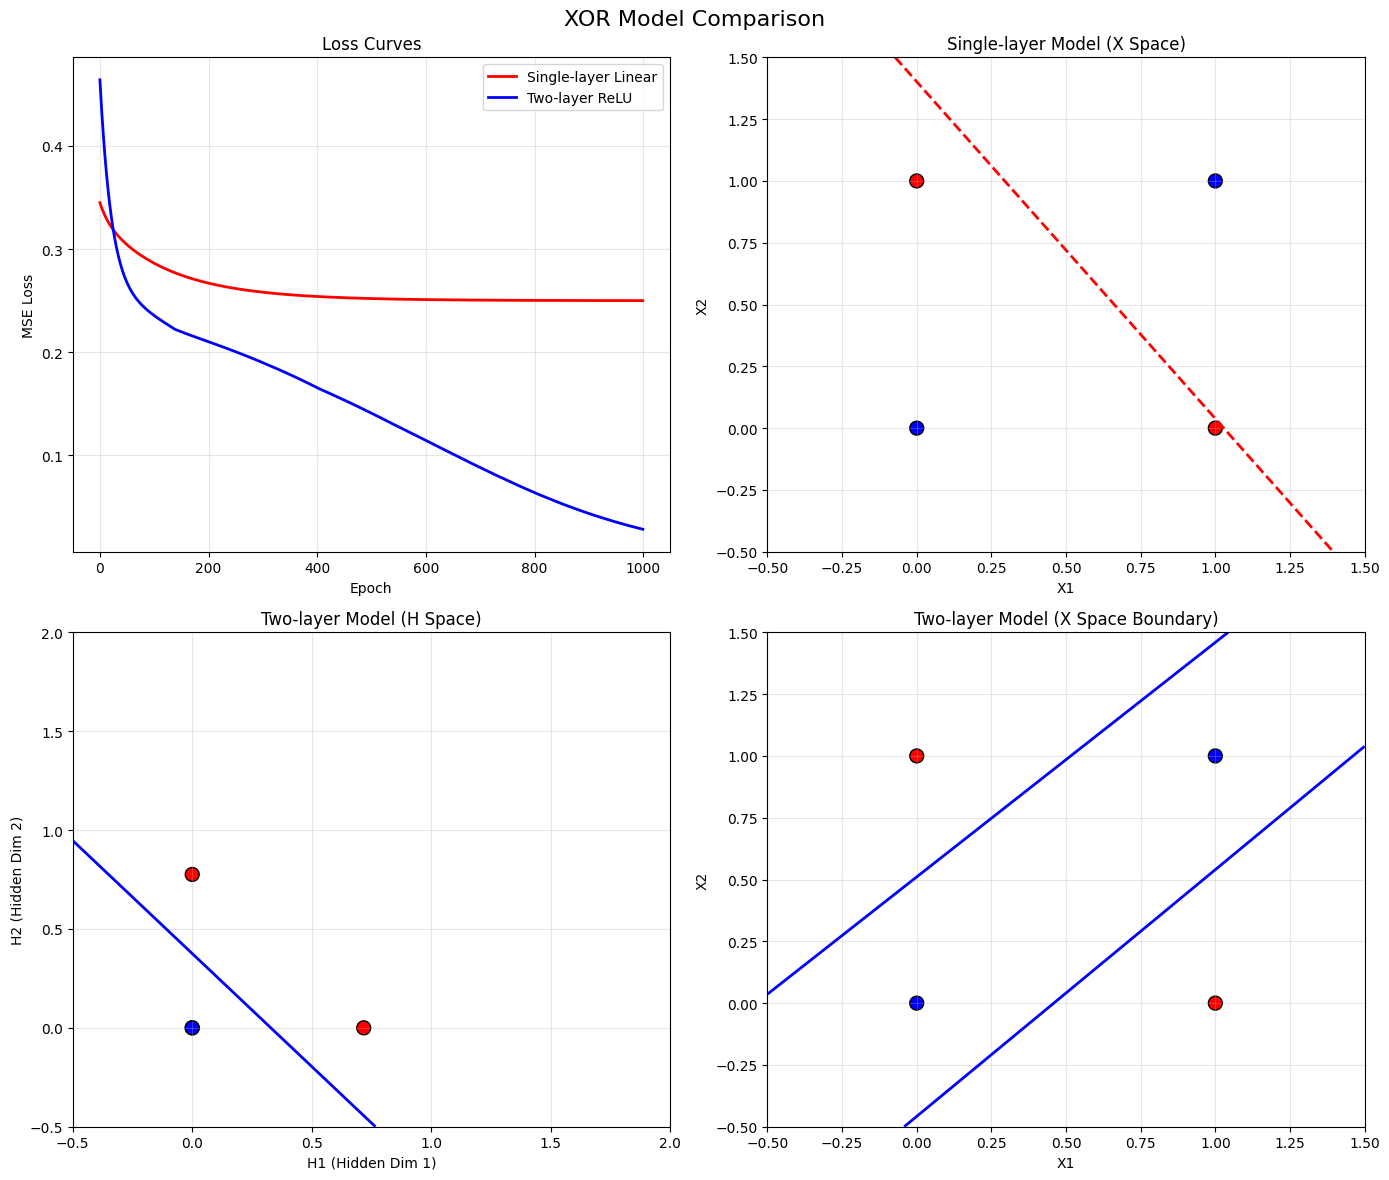

=== One Layer Linear Model Prediction Results ===
results : tensor([[0.4858],
        [0.4959],
        [0.4996],
        [0.5098]], grad_fn=<AddmmBackward0>)
parameters : [array([[0.01385745, 0.01016663]], dtype=float32), array([0.48575202], dtype=float32)]
=== Two-layer ReLU Model Prediction Results ===
results : tensor([[0.1861],
        [0.8341],
        [0.8710],
        [0.1864]], grad_fn=<AddmmBackward0>)
parameters : [array([[ 0.71897334, -0.7203622 ],
       [-0.7753964 ,  0.8173231 ]], dtype=float32), array([-0.00093385, -0.04164434], dtype=float32), array([[0.95381725, 0.8353898 ]], dtype=float32), array([0.18612398], dtype=float32)]


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the XOR input and output data
X = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]], dtype=torch.float32)
Y = torch.tensor([[0.0], [1.0], [1.0], [0.0]], dtype=torch.float32)

# Define feedforward neural network
class LinearModle(nn.Module):
    """One layer linear model"""
    def __init__(self):
        super(LinearModle, self).__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        x = self.layer(x)
        return x
    
class ReluModel(nn.Module):
    """Two layer model with ReLU activation"""
    def __init__(self, hidden_dim=2):
        super(ReluModel, self).__init__()
        self.hidden = nn.Linear(2, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
# Training function
def trian(model, X, Y, epochs=1000, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = []

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return loss_history, model

# visualization function
def plot_results(linear_loss, relu_loss, linear_model, relu_model):
    # create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('XOR Model Comparison', fontsize=16)

    # ---------------- Subplot 1: Loss Curves (Both Models) ----------------
    ax1 = axes[0, 0]
    ax1.plot(linear_loss, label='Single-layer Linear', color='red', linewidth=2)
    ax1.plot(relu_loss, label='Two-layer ReLU', color='blue', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('MSE Loss', fontsize=10)
    ax1.set_title('Loss Curves', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ---------------- Subplot 2: Single-layer Model - Final Layer (X Space) + Decision Boundary ----------------
    ax2 = axes[0, 1]
    # Generate grid in X space
    x1 = np.linspace(-0.5, 1.5, 100)
    x2 = np.linspace(-0.5, 1.5, 100)
    X1, X2 = np.meshgrid(x1, x2)
    grid = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32)
    
    #  Single-layer model output in X space
    linear_out = linear_model(grid).detach().numpy().reshape(X1.shape)
    
    # Plot original X space sample points
    ax2.scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap='bwr', s=100, edgecolors='black')
    # draw decision boundary in X space
    ax2.contour(X1, X2, linear_out, levels=[0.5], colors='red', linestyles='--', linewidths=2)
    print(linear_out)
    ax2.set_xlabel('X1', fontsize=10)
    ax2.set_ylabel('X2', fontsize=10)
    ax2.set_title('Single-layer Model (X Space)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-0.5, 1.5)
    ax2.set_ylim(-0.5, 1.5)

    # ---------------- Subplot 3: Two-layer Model - Final Layer (H Space) + Decision Boundary ----------------
    ax3 = axes[1, 0]
    # Get H space sample points
    relu_model(X)  # Forward pass to update hidden
    h_points = relu_model.relu(relu_model.hidden(X)).detach().numpy()  # H space coordinates of 4 samples
    
    # Generate grid in H space
    h1 = np.linspace(-0.5, 2.0, 100)
    h2 = np.linspace(-0.5, 2.0, 100)
    H1, H2 = np.meshgrid(h1, h2)
    h_grid = torch.tensor(np.c_[H1.ravel(), H2.ravel()], dtype=torch.float32)
    
    # Two-layer model output in H space
    h_out = relu_model.output(h_grid).detach().numpy().reshape(H1.shape)
    
    # Plot H space sample points
    ax3.scatter(h_points[:, 0], h_points[:, 1], c=Y.flatten(), cmap='bwr', s=100, edgecolors='black')
    # draw decision boundary in H space
    ax3.contour(H1, H2, h_out, levels=[0.5], colors='blue', linewidths=2)
    ax3.set_xlabel('H1 (Hidden Dim 1)', fontsize=10)
    ax3.set_ylabel('H2 (Hidden Dim 2)', fontsize=10)
    ax3.set_title('Two-layer Model (H Space)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-0.5, 2.0)
    ax3.set_ylim(-0.5, 2.0)

    # ---------------- Subplot 4: Two-layer Model - Original X Space Decision Boundary ----------------
    ax4 = axes[1, 1]
    # Two-layer model output in X space
    relu_out = relu_model(grid).detach().numpy().reshape(X1.shape)
    
    # Plot original X space sample points
    ax4.scatter(X[:, 0], X[:, 1], c=Y.flatten(), cmap='bwr', s=100, edgecolors='black')
    # draw decision boundary in X space
    ax4.contour(X1, X2, relu_out, levels=[0.5], colors='blue', linewidths=2)
    ax4.set_xlabel('X1', fontsize=10)
    ax4.set_ylabel('X2', fontsize=10)
    ax4.set_title('Two-layer Model (X Space Boundary)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(-0.5, 1.5)
    ax4.set_ylim(-0.5, 1.5)

    # show plots
    plt.tight_layout()
    plt.show()

def main():
    # train single-layer linear model
    linear_model = LinearModle()
    linear_loss, linear_model = trian(linear_model, X, Y, epochs=1000, lr=0.01)

    # train two-layer ReLU model
    relu_model = ReluModel()
    relu_loss, relu_model = trian(relu_model, X, Y, epochs=1000, lr=0.01)

    # 可视化结果
    plot_results(linear_loss, relu_loss, linear_model, relu_model)

    # 打印最终预测结果
    print("=== One Layer Linear Model Prediction Results ===")
    print(f"results : {linear_model(X)}")
    print(f"parameters : {[param.data.numpy() for param in linear_model.parameters()]}")
    print("=== Two-layer ReLU Model Prediction Results ===")
    print(f"results : {relu_model(X)}")
    print(f"parameters : {[param.data.numpy() for param in relu_model.parameters()]}")

main()